In [43]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

In [2]:
## load in the preprocessed data and the sale prices for training data
data = pd.read_csv('Master_DF.csv')
data.set_index('Id', inplace=True)

In [3]:
# import raw training data and get log of prices
train_raw = pd.read_csv('train.csv')
train_raw.set_index('Id', inplace=True)
logprices = np.log10(train_raw.SalePrice)

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
columns = list(data.columns)

/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [5]:
scaled = pd.DataFrame(data_scaled, columns=columns)
scaled.index +=1
train = scaled.loc[1:1460,]
test = scaled.loc[1461:2919,]

In [6]:
outliers = list(train_raw[(train_raw['GrLivArea']>4000) & (train_raw['SalePrice']<300000)].index)
outliers

[524, 1299]

In [7]:
##Drop some of the correlated and categorical variables
dropcols = ['MSSubClass','MasVnrArea','TotalBsmtSF','LowQualFinSF','GrLivArea','TotRmsAbvGrd']
droprows = outliers
trim = scaled.drop(columns=dropcols)
trim = trim.drop(droprows)
trimprices = logprices.drop(droprows)

In [22]:
train = trim.loc[1:1460,]
test = trim.loc[1461:2919,]
y = trimprices

R squared: 0.8768282961065885
Root Mean Squared Error: 0.060903423656027404


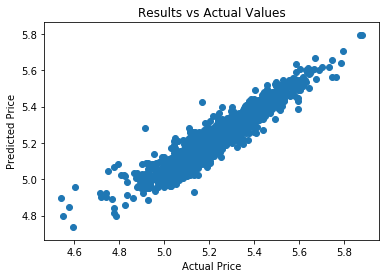

In [65]:
lasso = Lasso(alpha=0.01)
lasso.fit(train, trimprices)
yhat_lasso = lasso.predict(train)
plt.scatter(y, yhat_lasso)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",lasso.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_lasso))
print("Root Mean Squared Error:",RMSE)

R squared: 0.9011668944241464
Root Mean Squared Error: 0.05455536345130355


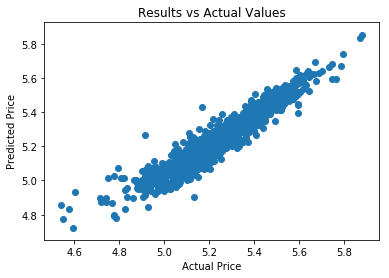

In [57]:
enet = ElasticNet(alpha=0.01)
enet.fit(train, trimprices)
yhat_enet = enet.predict(train)
plt.scatter(y, yhat_enet)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",enet.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_enet))
print("Root Mean Squared Error:",RMSE)

R squared: 0.9182717954027287
Root Mean Squared Error: 0.04961034092735686


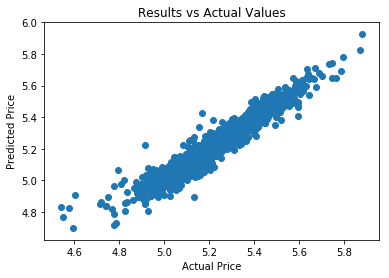

In [58]:
linreg = LinearRegression()
linreg.fit(train, trimprices)
yhat_linreg = linreg.predict(train)
plt.scatter(y, yhat_linreg)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",linreg.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_linreg))
print("Root Mean Squared Error:",RMSE)

Root Mean Squared Error: 0.05317251230102405


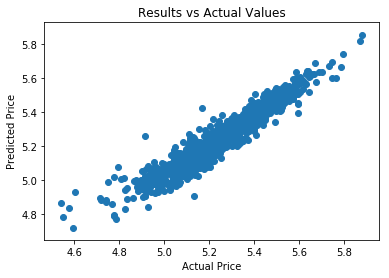

In [59]:
yhat_test_combined = (yhat_linreg + yhat_lasso + yhat_enet)/3
plt.scatter(y, yhat_test_combined)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
RMSE = math.sqrt(mean_squared_error(y, yhat_test_combined))
print("Root Mean Squared Error:",RMSE)

In [60]:
yhat_sub_enet = enet.predict(test)
yhat_sub_lasso = enet.predict(test)
yhat_sub_linreg = enet.predict(test)

In [61]:
submit_yhat = (yhat_sub_linreg + yhat_sub_lasso + yhat_sub_enet)/3

## Export to .csv for uploading

In [62]:
submission = pd.DataFrame({'Id':test.index, 'SalePrice': np.power(10, submit_yhat)})
submission.set_index('Id', inplace=True)
print(submission.head())
timestamp = datetime.now().strftime('%m-%d-%H-%M-%S')

      SalePrice
Id             
1461 122,032.80
1462 155,282.74
1463 172,942.98
1464 188,167.63
1465 191,454.28


In [63]:
submission.to_csv(f'submission_files/Sub{timestamp}.csv')